In [4]:
import os
import numpy as np

from utils import dataloader, FusionDataset, generate, plot_1d_statistic_over_time
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch

In [5]:
def safe_load_pickle(path):
    # Try loading in chunks to handle large integers
    with open(path, 'rb') as f:
        # First try with torch's built-in loading
        try:
            # Explicitly specify CPU and use default pickle protocol
            return torch.load(
                f, 
                map_location=lambda storage, loc: storage.cpu(),
            )
        except OverflowError:
            # If that fails, try reopening the file and using pickle directly
            f.seek(0)
            import pickle
            return pickle.load(f)

In [6]:
# Load predictions and latent samples from Thijs
trajectories = safe_load_pickle("../data/preds-traj.pkl")
latent_samples = safe_load_pickle("../data/preds-z.pkl")

/tmp/ipykernel_112056/2549519657.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(


In [56]:
import numpy as np

def estimate_derivative(x):
    """
    Estimate derivative of 2D array using forward differences along spatial dimension.
    Input shape: (time_steps, spatial_points)
    Returns array of same shape with padding of zeros at the beginning of spatial dimension
    
    Parameters:
    x: array of shape (time_steps, spatial_points)
    
    Returns:
    array of shape (time_steps, spatial_points) with spatial derivatives
    """
    time_steps, spatial_points = x.shape
    
    # Calculate differences along spatial dimension for all time steps
    derivative = x[:, 1:] - x[:, :-1]  # Shape: (time_steps, spatial_points-1)
    
    # Pad with zeros at the beginning of spatial dimension for each time step
    padded_derivative = np.zeros_like(x)  # Shape: (time_steps, spatial_points)
    padded_derivative[:, 1:] = derivative
    
    return padded_derivative

def PDE_plasma_density(n_pred, v_pred, n_true, v_true, B):
    """
        n: plasma density
        v: ion speed parallel to magnetic field
        B: strength of magnetic field
    """
    pred = estimate_derivative(n_pred * v_pred / B)
    true = estimate_derivative(n_true * v_true / B)
    return B**2 * (true - pred)**2

def PDE_plasma_momentum(n_pred, v_pred, temp_pred, n_true, v_true, temp_true, B, m):
    """
        n: plasma density
        v: ion speed parallel to magnetic field
        T: plasma temperature
        B: strength of magnetic field
    """
    pred = - B * estimate_derivative(n_pred * m * v_pred**2 / B) - estimate_derivative(2 * n_pred * np.e * temp_pred)
    true = - B * estimate_derivative(n_true * m * v_true**2 / B) - estimate_derivative(2 * n_true * np.e * temp_true)
    return (true - pred)**2

def PDE_plasma_energy(n_pred, v_pred, temp_pred, n_true, v_true, temp_true, B):
    """
        n: plasma density
        v: ion speed parallel to magnetic field
        T: plasma temperature
        B: strength of magnetic field
    """
    q = lambda n, v, T: 5 * n * np.e * T * v - 2000 * T**(5/2) * estimate_derivative(T)
    pred = -B * estimate_derivative(q(n_pred, v_pred, temp_pred) / B) + v_pred * estimate_derivative(2 * n_pred * temp_pred)
    true = -B * estimate_derivative(q(n_true, v_true, temp_true) / B) + v_true * estimate_derivative(2 * n_true * temp_true)
    return (true - pred)**2

def PDE_atom_momentum(n_a_pred, v_a_pred, n_a_true, v_a_true, m, T_a):
    """
        n_a: neutral atom density
        v_a: neutral atom speed parallel to magnetic field
        T_a: neutral temperature
    """
    pred = -1 * estimate_derivative(n_a_pred * m * v_a_pred**2) - estimate_derivative(np.e * n_a_pred * T_a)
    true = -1 * estimate_derivative(n_a_true * m * v_a_true**2) - estimate_derivative(np.e * n_a_true * T_a)
    return (true - pred)**2

In [ ]:
def scale(x):
    # These parameters have been precalculated on the training set
    sigma = torch.tensor([[6.07735822e+19, 9.96008140e+03, 5.33818657e+03, 1.03287412e+01, 1.43263560e+19, 1.05223976e+19, 1.15240628e+03, 1.72603208e+19]], device=self.device)
    mu = torch.tensor([[7.07982534e+19, 1.70274903e+04, 8.30559879e+03, 1.24850983e+01, 3.18866547e+18, 3.36626442e+18, 5.39373277e+02, 8.06264466e+18]], device=self.device)
    return (x - mu) / sigma

In [74]:
def calculate_PDE_loss_of_trajectory(x_pred, trajectory_name = "div1d_output_110.npz"):
    """Calculates the PDE losses for a trajectory loss
    """
    # ground truth and pde vars
    x_true, _, pde_vars = np.load("../data/all/" + trajectory_name).values()

    # scale 
    x_true = scale(x_treu)

    # trim prediction to maintain consistency in timesteps
    x_pred = x_pred[:x_true.shape[0], ...]
    
    # DIV1D values
    T_a         = pde_vars[..., 0]
    m           = pde_vars[..., 1]
    B           = pde_vars[..., 2]

    # predicted values
    n_pred      = x_pred[..., 0]
    v_pred      = x_pred[..., 1]
    temp_pred   = x_pred[..., 3]
    n_a_pred    = x_pred[..., 4]
    v_a_pred    = x_pred[..., 2]

    # predicted values
    n_true      = x_true[..., 0]
    v_true      = x_true[..., 1]
    temp_true   = x_true[..., 3]
    n_a_true    = x_pred[..., 4]
    v_a_true    = x_pred[..., 2]

    losses = {
        "plasma_density": PDE_plasma_density(n_pred, v_pred, n_true, v_true, B),
        "plasma_momentum": PDE_plasma_momentum(n_pred, v_pred, temp_pred, n_true, v_true, temp_true, B, m),
        "plasma_energy": PDE_plasma_energy(n_pred, v_pred, temp_pred, n_true, v_true, temp_true, B),
        "atom_momentum": PDE_atom_momentum(n_a_pred, v_a_pred, n_a_true, v_a_true, m, T_a)
    }

    return losses, x_true

In [75]:
# select random trajectory
trajectory = trajectories[0].detach().numpy()
losses, x_true = calculate_PDE_loss_of_trajectory(trajectory)

/tmp/ipykernel_112056/2597683331.py:54: RuntimeWarning: invalid value encountered in power
  q = lambda n, v, T: 5 * n * np.e * T * v - 2000 * T**(5/2) * estimate_derivative(T)


### Plotting

In [67]:
import matplotlib.pyplot as plt

def plot_1d_statistic_over_time(data, title):
    """
    Plot a single statistic over time.

    Args:
        data: np.array, shape (Time, Coordinate, Statistic), data to plot
        statistic_idx: int, index of the statistic to plot
        title: str, title of the plot
    """
    fig = plt.figure(figsize=(12, 6))
    plt.imshow(data.T, aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Position on magnetic line")

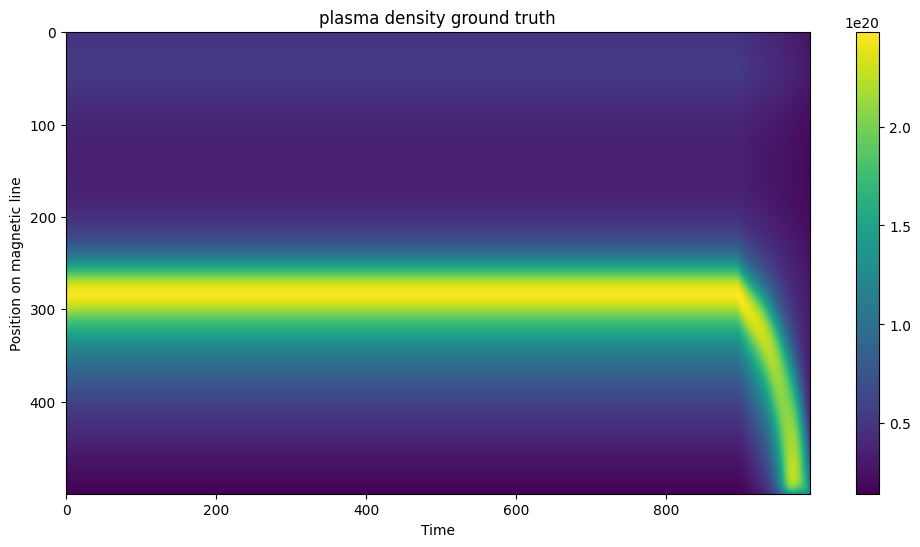

In [76]:
plot_1d_statistic_over_time(x_true[:,:,0], "plasma density ground truth")

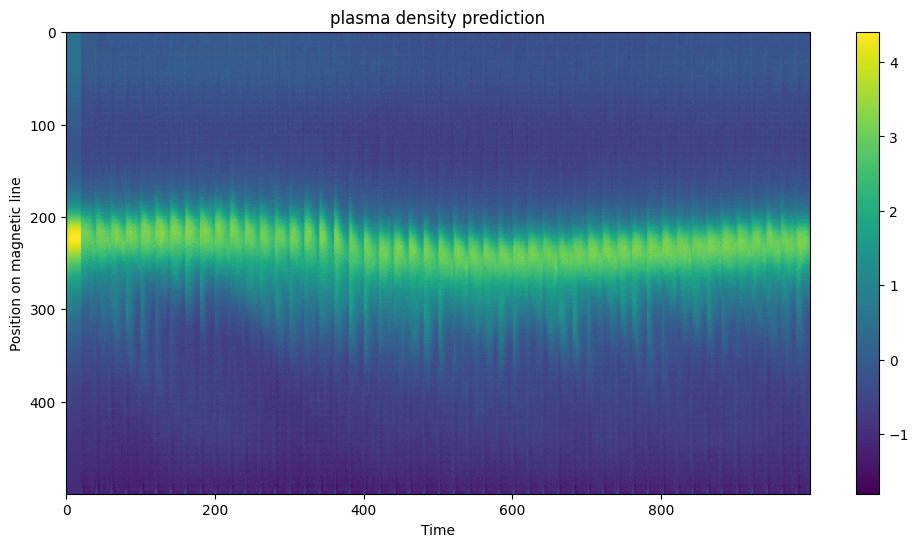

In [80]:
plot_1d_statistic_over_time(trajectory[:,:,0], "plasma density prediction")

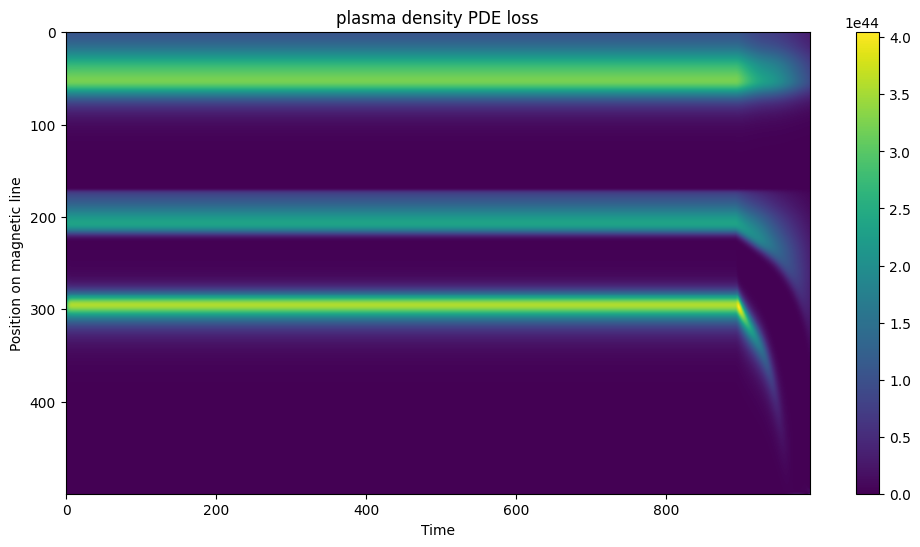

In [73]:
plot_1d_statistic_over_time(losses["plasma_density"], "plasma density PDE loss")

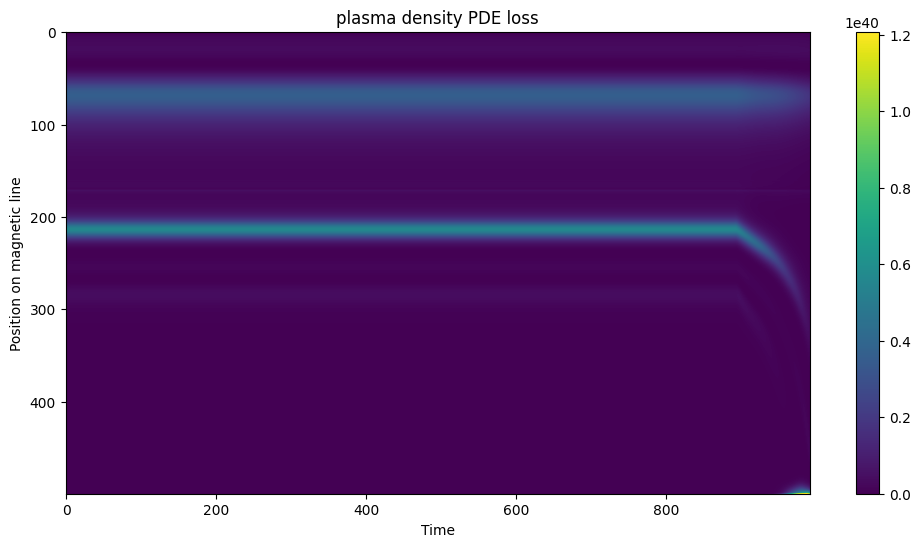

In [77]:
plot_1d_statistic_over_time(losses["plasma_momentum"], "plasma density PDE loss")